# Data Collection

Importing necessary libraries

In [100]:
# Standard library Import
import os
import warnings
import pickle

# Data Handling & Processing
import numpy as np
import pandas as pd
import yfinance as yf

# Machine Learning & Statistics
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler

# Deep Learning (PyTorch)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Time Series & Forecasting
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_plotly

# Visualization
import matplotlib.pyplot as plt
import mplfinance as mpf
import seaborn as sns

# Technical Analysis
import ta.momentum
import ta.trend
import ta.volatility

# Holiday Calendars
from workalendar.usa import UnitedStates



In [101]:
# Suppress all warnings
warnings.filterwarnings('ignore')

Getting the data

In [102]:
# creating a function to make the data collection much more easier
def get_data(tickers, period="2y", interval="1h"):
    """
    Fetches stock data for the specified tickers.

    Parameters:
    ----------
    tickers : list or str
        A list of ticker symbols or a single ticker symbol.
    period : str
        A string of periods accepted by yahoo finance API.
    interval : str
        A string of intervals accepted by yahoo finance API.

    Returns:
    -------
    pandas.DataFrame
        A DataFrame containing the stock data for the tickers.
    """
    data = yf.download(
        tickers = tickers,
        period = period,
        interval= interval
    )
    return data


In [103]:
COCA_medium_data = get_data("KO")

[*********************100%***********************]  1 of 1 completed


Data Cleaning

In [104]:
# A function that explores the data to help in making data cleaning decisions
def general_description(data):
    """
    Generates and prints general descriptive statistics and information for data cleaning purposes.

    This function provides essential details about the DataFrame, such as head of the DataFrame, missing values,
    summary statistics, number of duplicates (if any), number of columns with erroneous negative values (if any) and skewness measure, to aid in data cleaning and preprocessing steps.

    Parameters
    ----------
    data : pandas DataFrame
        DataFrame that will be analyzed for general description. 

    Returns
    -------
    None
        This function prints various statistics and information.
    """
    print("Head of the data:\n\t", data.head())
    
    print("\n\nInformation on data types:\n\t")
    print(data.info())

    print("\n\nData shape:\n\t", data.shape)

    # printing description of data
    print(f"\n\nDescription:\n\t", data.describe())
    
    # looking at the number of missing values
    print(f"\n\nMissing values count:\n\t", data.isna().sum())
    
    number_of_duplicates = data.duplicated().sum()
    print("\n\nNumber of duplicates:\n\t", number_of_duplicates)

    # calculating skewness and seeing how many rows are highly skewed
    number_skewed_columns = (np.abs(data.skew()) > 1).sum()
    print("\n\nNumber of skewed columns:\n\t", number_skewed_columns)

    # checking to see if there are any any unrealistic negative values
    number_of_negatives = ((data < 0).sum() != 0).sum()
    print("\n\nNumber of columns with negative values:\n\t", number_of_negatives)

In [105]:
general_description(COCA_medium_data)

Head of the data:
	 Price                          Close       High        Low       Open   Volume
Ticker                            KO         KO         KO         KO       KO
Datetime                                                                      
2023-01-30 19:30:00+00:00  60.615002  60.697300  60.570000  60.599998        0
2023-01-30 20:30:00+00:00  60.650002  60.700001  60.560001  60.610001  2491418
2023-01-31 14:30:00+00:00  60.744999  61.145000  60.695000  60.980000  1753909
2023-01-31 15:30:00+00:00  60.625000  60.775002  60.509998  60.750000  1096604
2023-01-31 16:30:00+00:00  60.740002  60.759998  60.599998  60.625000   942754


Information on data types:
	
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3495 entries, 2023-01-30 19:30:00+00:00 to 2025-01-30 19:30:00+00:00
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   (Close, KO)   3495 non-null   float64
 1   (High, KO)    3495 non-null  

In [106]:
def get_plots(data):
    """
    Generates and displays visualizations for stock price data.

    This function:
    1. Handles MultiIndex columns by flattening them if necessary.
    2. Plots a line chart showing the trend of closing prices over time.
    3. Plots a boxplot to visualize the distribution of stock prices.

    Parameters:
    data (pandas.DataFrame): A DataFrame containing stock price data with a DateTime index.
                             It must include a 'Close' column for the line plot.

    Returns:
    None: The function displays the plots directly.
    """
    if isinstance(data.columns, pd.MultiIndex):
        data = data.droplevel(axis=1, level=1)
    sns.lineplot(data, x=data.index, y="Close")
    plt.show()
    sns.boxplot(data)
    plt.show()


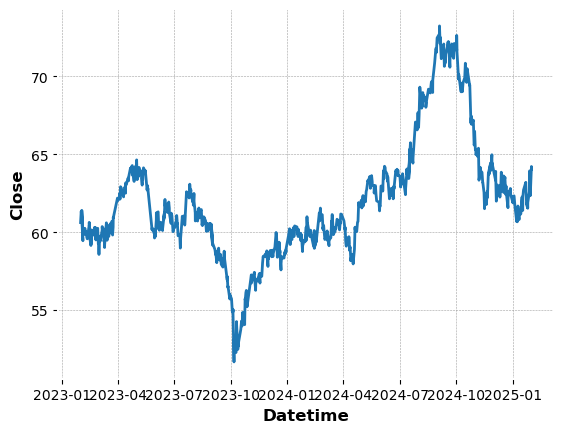

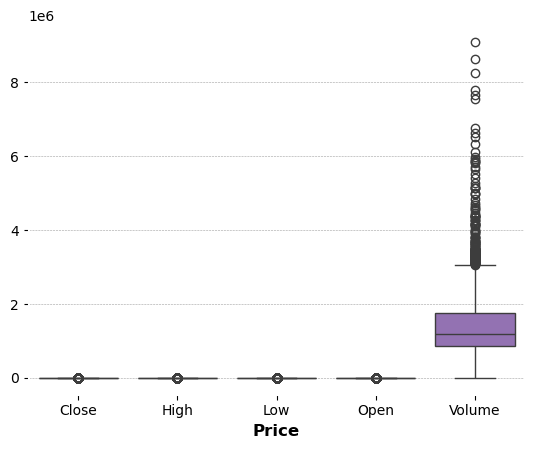

In [107]:
get_plots(COCA_medium_data)

In [108]:
# A function to clean data
def clean_data(data, relevel_column=True, fill_na=True, winsorize_outliers=True):
    """
    Cleans stock market data by optionally releveling column indices, filling missing values, 
    and applying IQR-based Winsorization to handle outliers.

    Parameters:
    -----------
    data : pandas.DataFrame
        The input DataFrame containing stock data.
    relevel_column : bool, optional (default=True)
        If True, drops the second-level column index if present.
    fill_na : bool, optional (default=True)
        If True, forward-fills missing values in the dataset.
    winsorize_outliers : bool, optional (default=True)
        If True, caps extreme values in the 'Close' and 'Volume' columns using an adaptive IQR-based Winsorization.

    Returns:
    --------
    pandas.DataFrame
        The cleaned DataFrame with the specified transformations applied.
    """

    # Drop second-level column index only if it exists
    if relevel_column and isinstance(data.columns, pd.MultiIndex):
        data = data.droplevel(axis=1, level=1)
        print("Columns re-leveled.")

    # Forward-fill missing values
    if fill_na and data.isna().sum().max() > 0:
        data = data.ffill()
        print("Missing values filled with forward fill.")

    # Apply adaptive Winsorization based on IQR
    if winsorize_outliers:
        for column in ["Close", "Volume"]:
            Q1 = data[column].quantile(0.25)
            Q3 = data[column].quantile(0.75)
            IQR = Q3 - Q1
            low_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            # Capping values outside the bounds
            data[column] = np.where(data[column] < low_bound, low_bound, data[column])
            data[column] = np.where(data[column] > upper_bound, upper_bound, data[column])
        print("Outliers winsorized.")
    return data


In [109]:
COCA_clean = clean_data(COCA_medium_data)

Columns re-leveled.
Outliers winsorized.


# EDA

### Univariate EDA

Summary statistics at different times

In [110]:
# A function to summarize closing prices at different intervals
def summary(data, five_days=True, week=True, month=True, year=True):
    """
    Computes and prints summary statistics for the closing prices of a stock over different time periods.

    Parameters:
    data (pandas.DataFrame): A DataFrame containing stock data with a DateTime index. 
                             It must have a 'Close' column representing the stock's closing prices.
    five_days (bool, optional): If True, prints summary statistics for the last 5 days. Default is True.
    week (bool, optional): If True, prints summary statistics for the last 7 days. Default is True.
    month (bool, optional): If True, prints summary statistics for the last 1 month. Default is True.
    year (bool, optional): If True, prints summary statistics for the last 1 year. Default is True.

    Returns:
    None: The function prints the summary statistics directly.
    """
    data = pd.DataFrame(data)  # Ensure data is a DataFrame

    if five_days:
        index_start = data.index.max() - pd.Timedelta(days=5)
        print("Five days' summary:\n", data.loc[index_start:]["Close"].describe(), "\n")

    if week:
        index_start = data.index.max() - pd.Timedelta(days=7)
        print("Last week's summary:\n", data.loc[index_start:]["Close"].describe(), "\n")

    if month:
        index_start = data.index.max() - pd.DateOffset(months=1) 
        print("Last month's summary:\n", data.loc[index_start:]["Close"].describe(), "\n")

    if year:
        index_start = data.index.max() - pd.DateOffset(years=1)
        print("Last year's summary:\n", data.loc[index_start:]["Close"].describe())


In [111]:
summary(COCA_clean)

Five days' summary:
 count    27.000000
mean     63.307837
std       0.518994
min      62.340000
25%      62.952200
50%      63.224998
75%      63.780001
max      64.214996
Name: Close, dtype: float64 

Last week's summary:
 count    36.000000
mean     62.898100
std       0.849244
min      61.535000
25%      62.232500
50%      63.066601
75%      63.475076
max      64.214996
Name: Close, dtype: float64 

Last month's summary:
 count    141.000000
mean      62.049468
std        0.801989
min       60.665001
25%       61.580002
50%       61.910000
75%       62.455002
max       64.214996
Name: Close, dtype: float64 

Last year's summary:
 count    1746.000000
mean       63.855862
std         3.352106
min        57.959999
25%        61.365002
50%        63.007500
75%        67.015074
max        69.164997
Name: Close, dtype: float64


In [112]:
# A function to generate candlestick plots
def plot_candlestick(data):
    """
    Plots candlestick charts of stock prices at different time intervals:
    yearly, monthly, weekly, daily, and hourly.

    Parameters:
    data (pandas.DataFrame): A DataFrame containing stock data with a DateTime index.
                             It must have 'Open', 'High', 'Low', and 'Close' columns.

    Returns:
    None: Displays the candlestick plots.
    """
    # Ensure data is sorted
    data = data.sort_index()

    # Resample data for different time intervals
    resampled_data = {
        "Yearly": data.resample('Y').agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last'}),
        "Monthly": data.resample('M').agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last'}),
        "Weekly": data.resample('W').agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last'}),
        "Daily": data.resample('D').agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last'}),
        "Hourly": data.resample('H').agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last'})
    }

    # Plot candlestick charts for each interval
    for period, df in resampled_data.items():
        if df.dropna().empty:  # Skip empty dataframes
            continue
        print(f"Plotting {period} Candlestick Chart")
        mpf.plot(df.dropna(), type='candle', style='charles', title=f"{period} Candlestick Chart", ylabel='Price', volume=False)



Plotting Yearly Candlestick Chart


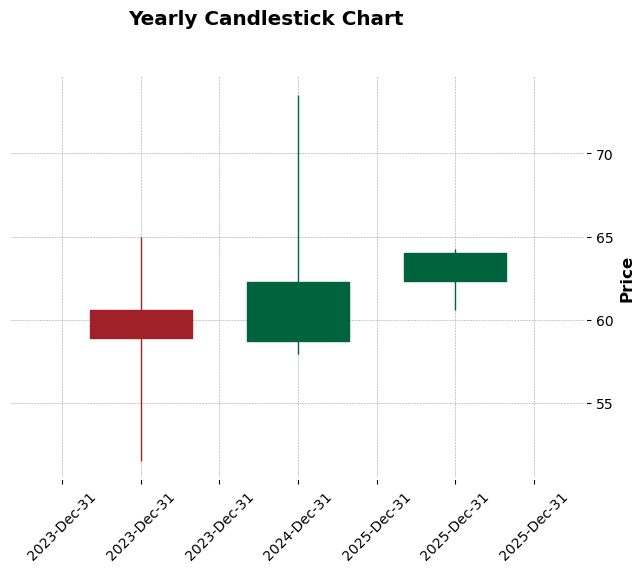

Plotting Monthly Candlestick Chart


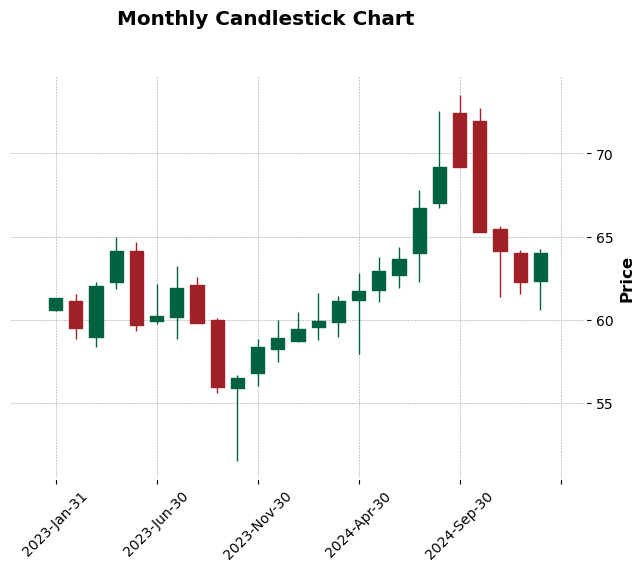

Plotting Weekly Candlestick Chart


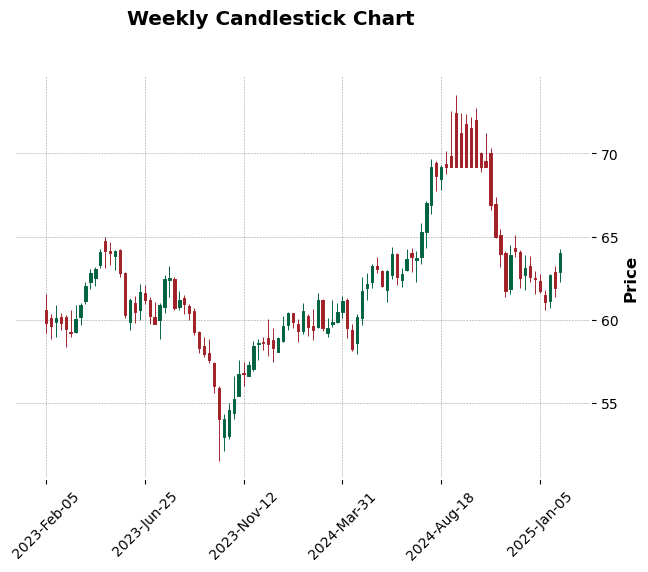

Plotting Daily Candlestick Chart


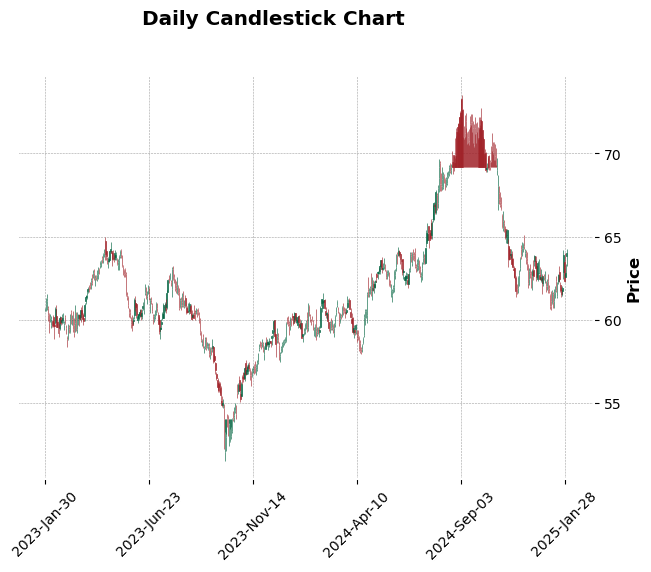

Plotting Hourly Candlestick Chart


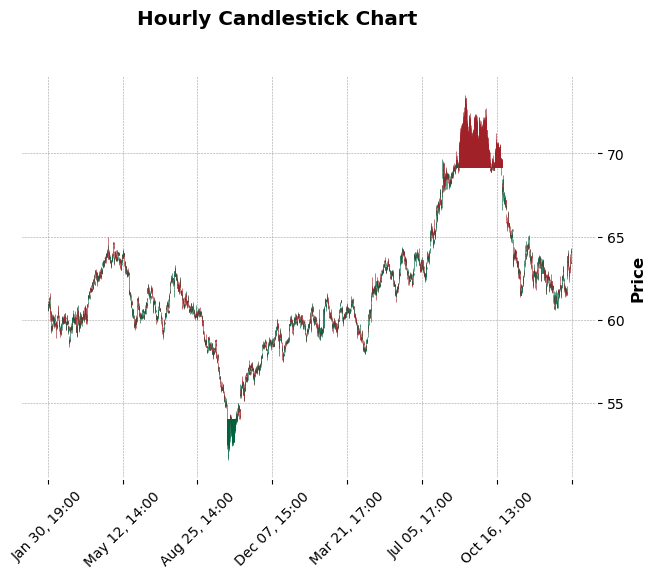

In [113]:
plot_candlestick(COCA_clean)

### Bivariate EDA

relation between different stocks

In [114]:
def stocks_correlation(data_A, data_B, ticker_A="Stock A", ticker_B="Stock B"):
    """
    Calculates and visualizes the correlation between the closing prices of two stocks.

    Parameters:
    - data_A (pd.DataFrame): DataFrame containing stock A's historical data with a "Close" column.
    - data_B (pd.DataFrame): DataFrame containing stock B's historical data with a "Close" column.
    - ticker_A (str, optional): Ticker symbol or name of stock A (default: "Stock A").
    - ticker_B (str, optional): Ticker symbol or name of stock B (default: "Stock B").

    Prints:
    - The Pearson correlation coefficient between the two stocks' closing prices.

    Displays:
    - A scatter plot with stock A's closing price on the x-axis and stock B's closing price on the y-axis.

    Example Usage:
    >>> stocks_correlation(meta_df, apple_df, "META", "AAPL")
    """
    correlation = data_A["Close"].corr(data_B["Close"])
    print(f"Correlation between {ticker_A} and {ticker_B}: {correlation:.2f}")
    
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=data_A["Close"], y=data_B["Close"], s=10, edgecolor=None)
    
    plt.xlabel(f"{ticker_A} Closing Price")
    plt.ylabel(f"{ticker_B} Closing Price")
    plt.title(f"Scatter Plot: {ticker_A} vs {ticker_B}")
    
    plt.show()


Correlation between COCA_A and COCA_B: 1.00


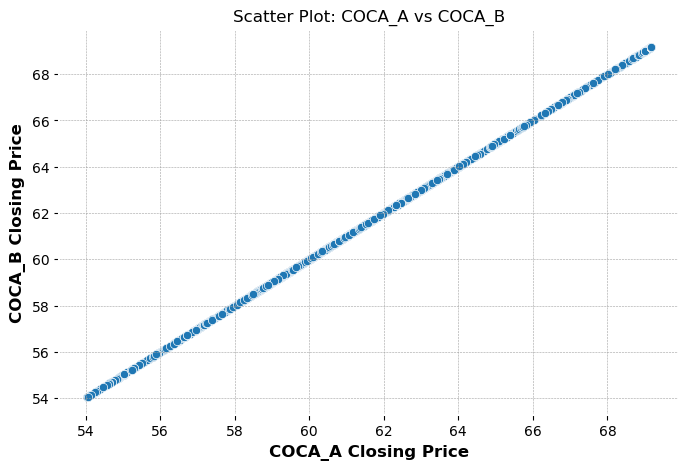

In [115]:
stocks_correlation(COCA_clean, COCA_clean, "COCA_A", "COCA_B")

relation between closing price and volume

In [116]:
COCA_clean["Close"].corr(COCA_clean["Volume"])

-0.11358326996413583

# Predictive modelling

### feature engineering

In [117]:
def get_holiday_columns(data):
    """
    Adds holiday-related columns to a DataFrame and plots correlations.

    This function retrieves public holidays in the United States within the date range 
    of the given DataFrame's index, calculates 5 days before and after each holiday, 
    and adds two new columns to the DataFrame: 
    - "Before_Holiday": Indicates whether the date is within 5 days before a holiday.
    - "After_Holiday": Indicates whether the date is within 5 days after a holiday.

    Additionally, it visualizes the correlation of the "Close" column with the new columns 
    using a heatmap.

    Parameters:
        data (pandas.DataFrame): A pandas DataFrame with a DatetimeIndex and a "Close" column.

    Returns:
        pandas.DataFrame: The original DataFrame with the added "Before_Holiday" and 
                          "After_Holiday" columns.
    Notes:
        - The function uses the `UnitedStates` holiday calendar from the `holidays` package.
        - The holiday range extends to include dates before the next year's Christmas 
          for accurate handling of year-end holidays.
        - The correlation heatmap provides insights into the relationships between 
          the closing price and holiday proximity.
          """
    # getting a numpy array of all the holidays in united states for the years in our data
    calendar = UnitedStates()
    holidays = list()
    for year in range(data.index.min().year, data.index.max().year + 2): #+2 to consider the days before next year's christmas
        holidays.extend(calendar.holidays(year))
    holidays = np.array([holiday[0] for holiday in holidays])

    # identifying date ranges for 5 days before and after the holiday
    before_holiday = np.concatenate([holidays - pd.Timedelta(days=day) for day in range(1, 6)])
    after_holiday = np.concatenate([holidays + pd.Timedelta(days=day) for day in range(1, 6)])

    # Consider the holiday itself as part of the before holiday array.
    before_holiday = np.concatenate((holidays, before_holiday))

    # Adding dummy values columns based on before_holiday and after_holiday
    data["Before_Holiday"] = np.where(np.isin(data.index.date, before_holiday), 1, 0)
    data["After_Holiday"] = np.where(np.isin(data.index.date, after_holiday), 1, 0)
    print("Two columns added.")

    # plotting correlation
    sns.heatmap(data[["Close", "Before_Holiday", "After_Holiday"]].corr(), annot=True)
    plt.show()
    

Two columns added.


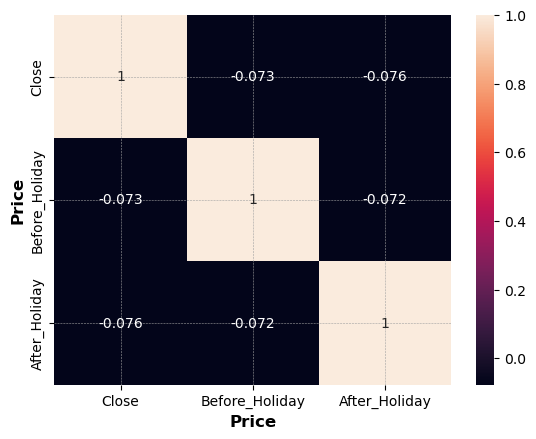

In [118]:
get_holiday_columns(COCA_clean)

In [119]:
def get_columns_outliers(data):
    """
    Identifies and returns the column names that contain outliers in the input DataFrame.

    This function detects columns that have outliers based on inter-quartile range (IQR). 
    It returns a list of columns where outliers are detected.

    Parameters
    ----------
    data : pandas DataFrame
        The input DataFrame containing the data to be analyzed for outliers.

    Returns
    -------
    outlier_columns : list
        A list of column names (or multi-level column combinations if the DataFrame has a multi-level column index)
        that contain outliers.

    Notes
    -----
    The function assumes that outliers are defined as values beyond a certain threshold (1.5*IQR).
    """

    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - (1.5 * IQR)
    upper = Q3 + (1.5 * IQR)

    # seeing if a column has outliers or not
    # we only want to winsorize columns with outliers
    outlier_data = ((data < lower) | (data > upper)).sum() != 0
    
    # getting a list of columns with outliers in them
    outlier_columns = outlier_data[outlier_data==True].index
    
    return outlier_columns
    

In [120]:
def feature_engineering_and_save_data(data, file_name, ema_span=20, bb_window=20, macd_fast=12, macd_slow=26, atr_window=14):
    """
    Perform feature engineering on a stock market DataFrame by adding common technical indicators.

    This function adds the following features to the input DataFrame:
        - Exponential Moving Average (EMA) based on the closing price.
        - Relative Strength Index (RSI) based on the closing price.
        - Bollinger Bands (Lower and Upper) based on the closing price.
        - Moving Average Convergence Divergence (MACD) based on the closing price.
        - Average True Range (ATR) based on the high, low, and close prices.
    
    It also saves the data to /datasets/ 

    Parameters:
    ----------
    data : pandas.DataFrame
        Input DataFrame containing stock market data with the following columns:
        - 'Open', 'High', 'Low', 'Close', and 'Volume'.
        The DataFrame index must be a pandas DateTimeIndex.
    file_name : str
        The name with which the data will be saved ot the /Datasets/ directory.

    ema_span : int, optional (default=20)
        The window size for calculating the Exponential Moving Average (EMA).

    bb_window : int, optional (default=20)
        The window size for calculating Bollinger Bands (Lower and Upper).

    macd_fast : int, optional (default=12)
        The fast window size for calculating the MACD line.

    macd_slow : int, optional (default=26)
        The slow window size for calculating the MACD line.

    atr_window : int, optional (default=14)
        The window size for calculating the Average True Range (ATR).

    Returns:
    -------
    pandas.DataFrame
        A modified DataFrame with the added technical indicators as new columns.
        The first `max(ema_span, rsi_window, bb_window, macd_slow, atr_window)` rows are dropped 
        to account for incomplete rolling window calculations.

    Notes:
    -----
    - The function modifies the input DataFrame in place but also returns it for flexibility.
    - The function also fills generated missing values using mean/median.

    Example:
    --------
    >>> import pandas as pd
    >>> import yfinance as yf
    >>> from ta import add_all_ta_features
    >>> df = yf.download("AAPL", start="2023-01-01", end="2023-12-31")
    >>> df = feature_engineering(df)
    >>> print(df.head())
    """
    data["EMA"] = data["Close"].ewm(span=ema_span).mean()

    data["BB_Low"] = ta.volatility.bollinger_lband(data["Close"], window=bb_window)
    data["BB_High"] = ta.volatility.bollinger_hband(data["Close"], window=bb_window)
    data["MACD"] = ta.trend.macd(data["Close"], window_fast=macd_fast, window_slow=macd_slow)
    data["ATR"] = ta.volatility.average_true_range(data["High"], data["Low"], data["Close"], window=atr_window)

  
    # New calculated feature will have some missing values and outliers
    # the following code deals with them
    means  = data.mean().to_dict() # getting mean for each column
    medians = data.median().to_dict() # getting median for each column
    outlier_columns = get_columns_outliers(data) # getting columns with outliers

    # filling missing values accordingly
    for column in data.columns:
        if column in outlier_columns:
            data[column] = data[column].fillna(medians[column])
        else:
            data[column] = data[column].fillna(means[column])

    # Define the path to save the file
    file_path = f"Datasets\{file_name}.csv"

    # Create the directory if it doesn't exist
    os.makedirs(os.path.dirname(file_path), exist_ok=True)

    # Save the dataframe to CSV
    data.to_csv(file_path)
    
    return data

In [121]:
COCA = feature_engineering_and_save_data(COCA_clean, "test_data")
COCA.tail()

Price,Close,High,Low,Open,Volume,Before_Holiday,After_Holiday,EMA,BB_Low,BB_High,MACD,ATR
Datetime,,,,,,,,,,,,
2025-01-30 15:30:00+00:00,63.470100,63.744999,63.459999,63.709999,888641.0,0,0,63.027734,62.279471,64.140249,0.205899,0.386430
2025-01-30 16:30:00+00:00,63.430000,63.485001,63.230000,63.450001,972751.0,0,0,63.066045,62.299640,64.077581,0.213183,0.377042
2025-01-30 17:30:00+00:00,64.214996,64.235001,63.389999,63.430000,1491164.0,0,0,63.175469,62.257313,64.150407,0.279081,0.410468
2025-01-30 18:30:00+00:00,64.114998,64.285004,63.990002,64.220001,1201615.0,0,0,63.264948,62.235747,64.189972,0.319552,0.402220
2025-01-30 19:30:00+00:00,64.014397,64.120003,64.014397,64.114998,400694.0,0,0,63.336324,62.222562,64.216598,0.339594,0.381033


### Arima

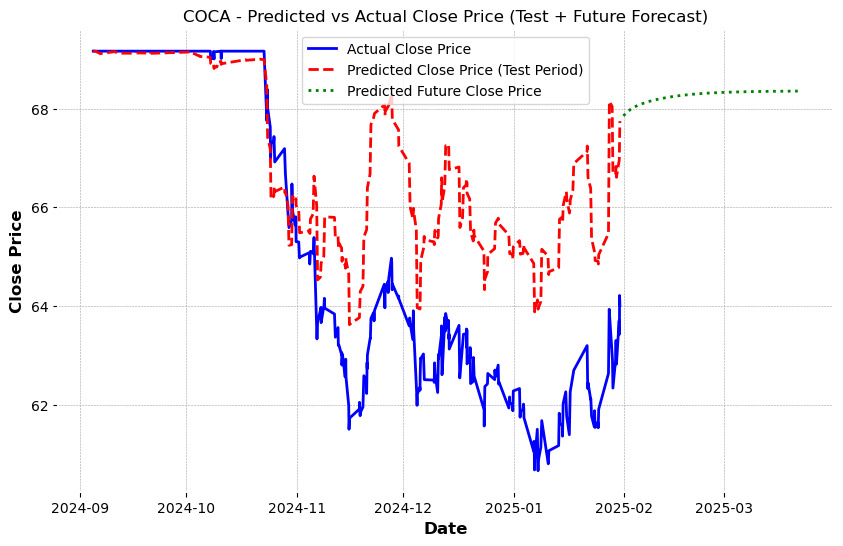

In [122]:
data = COCA.copy()

# Train-Test Split (80% train, 20% test)
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

train_close = train['Close']
test_close = test['Close']

# Define the external regressors (indicators)
train_exog = train.drop(columns=["Close", "High", "Low", "Open"])
test_exog = test.drop(columns=["Close", "High", "Low", "Open"])

# Fit ARIMA model with external regressors (order (p, d, q) = (5, 1, 0) )
model = ARIMA(train_close, exog=train_exog, order=(5, 1, 0))
model_fit = model.fit()

# Forecasting each exogenous variables
steps = 50
def exog_prediction(data, exog, order=(5,1,0), steps=steps):
    exog_model = ARIMA(data[exog], order=order)
    exog_fit = exog_model.fit()

    exog_future = exog_fit.forecast(steps=steps)
    return exog_future

# Predict future values for each indicator
EMA_future = exog_prediction(COCA, "EMA")
Volume_future = exog_prediction(COCA, "Volume")
B_Holiday = exog_prediction(COCA, "Before_Holiday")
A_Holiday = exog_prediction(COCA, "After_Holiday")
BB_Low = exog_prediction(COCA, "BB_Low")
BB_High = exog_prediction(COCA, "BB_High")
MACD = exog_prediction(COCA, "MACD")
ATR = exog_prediction(COCA, "ATR")

# Concatenate the future exogenous data
new_exog = pd.concat([Volume_future, B_Holiday, A_Holiday, EMA_future, BB_Low, BB_High, MACD, ATR], axis=1)
new_exog.columns = ["Volume", "Before_Holiday", "After_Holiday", "EMA", "BB_Low", "BB_High", "MACD", "ATR"]

# Combine test exogenous with future exogenous data
exog_combined = pd.concat([test_exog, new_exog])

# Forecast the future values including beyond the test period
forecast = model_fit.forecast(steps=len(test_close) + steps, exog=exog_combined)

# Adjusting the forecast index to start after the last date in test_close
forecast_index_future = pd.date_range(start=test_close.index[-1] + pd.Timedelta(days=1), periods=steps, freq=test_close.index.freq)

# Plot Predicted vs Actual
plt.figure(figsize=(10, 6))
plt.plot(test_close.index, test_close, color='blue', label='Actual Close Price')
plt.plot(test_close.index, forecast[:len(test)], color='red', linestyle='--', label='Predicted Close Price (Test Period)')
plt.plot(forecast_index_future, forecast[len(test):], color='green', linestyle=':', label='Predicted Future Close Price')  # Beyond Test Data
plt.title(f'COCA - Predicted vs Actual Close Price (Test + Future Forecast)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


In [123]:
# Ensure the forecast for the test period aligns with the test period
predicted_test_values = forecast[:len(test)]

# Calculate MAPE
mape = np.mean(np.abs((test_close.values - predicted_test_values.values) / test_close.values)) 

print(f"MAPE (Mean Absolute Percentage Error) for the test period: {mape:.2f}")


MAPE (Mean Absolute Percentage Error) for the test period: 0.03


### LSTM

In [124]:
# function to split data to training and testing data
def split_test_val_train(data, test_size=0.15, val_size=0.15):
    """
    Split sequential data into train, validation, and test sets.
    
    Args:
        data (DataFrame): The input sequential data.
        test_size (float): Fraction of data to use as the test set.
        val_size (float): Fraction of training data to use as the validation set.
    
    Returns:
        tuple: (data_train, data_val, data_test)
    """

    # Calculate test splitting index
    test_splitting_index = int(data.shape[0] * (1 - test_size))
    data_train_val = data.iloc[:test_splitting_index]
    data_test = data.iloc[test_splitting_index:]

    # Calculate validation splitting index for the remaining train set
    val_splitting_index = int(data_train_val.shape[0] * (1 - val_size))
    data_train = data_train_val.iloc[:val_splitting_index]
    data_val = data_train_val.iloc[val_splitting_index:]
    return data_train, data_val, data_test

In [125]:
def get_sequence(data, seq_length=10):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data.iloc[i : (i+seq_length), 0:]
        y = data.iloc[(i+seq_length), 0]

        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [126]:
def get_dataloader(X, y, batch_size=32, shuffle=False):
    data = TensorDataset(
        torch.from_numpy(X).float(),
        torch.from_numpy(y).float()
    )
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=shuffle, drop_last=True)
    return dataloader

In [127]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size=32, num_layers=2, dropout=0.2):
        super().__init__()
        self.LSTM = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout  # Apply dropout between LSTM layers
        )
        self.dropout = nn.Dropout(p=dropout)  # Dropout after LSTM output
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        outputs, _ = self.LSTM(x)
        output = self.dropout(outputs[:, -1, :])  # Use the last time step and apply dropout
        output = self.fc(output)
        return output


In [128]:
def train_and_test(data, lr=0.0001, epochs=20, test_model=True, test_size=0.15, val_size=0.15, seq_length=10, batch_size=32, shuffle=False, hidden_size=32, num_layers=2, dropout=0.2):
    """
    Train and test an LSTM model for time series forecasting using a single MinMaxScaler.

    Parameters:
    - data (pd.DataFrame): The dataset containing stock market data, where the first column is time, 
      the second column is the target variable (e.g., "Close"), and the remaining columns are features.
    - lr (float, optional): Learning rate for the Adam optimizer (default: 0.0001).
    - epochs (int, optional): Number of training epochs (default: 200).
    - test_model (bool, optional): Whether to evaluate the model on the test set (default: False).
    - test_size (float, optional): Proportion of data used for testing (default: 0.15).
    - val_size (float, optional): Proportion of data used for validation (default: 0.15).
    - seq_length (int, optional): Sequence length for LSTM input (default: 10).
    - batch_size (int, optional): Number of samples per batch in training (default: 32).
    - shuffle (bool, optional): Whether to shuffle training data (default: False).
    - hidden_size (int, optional): Number of hidden units per LSTM layer (default: 32).
    - num_layers (int, optional): Number of stacked LSTM layers (default: 2).
    - dropout (float, optional): Dropout rate for regularization (default: 0.2).

    Returns:
    - net (torch.nn.Module): The trained LSTM model.

    Functionality:
    1. **Data Scaling**: The function applies a MinMaxScaler to scale both target and feature variables.
    2. **Data Splitting**: The dataset is split into training, validation, and testing sets.
    3. **Sequence Generation**: Converts time-series data into sequential inputs for LSTM training.
    4. **Model Training**: Trains an LSTM network using Mean Squared Error (MSE) loss and Adam optimizer.
    5. **Validation**: Computes validation loss after each epoch.
    6. **Testing (Optional)**: Evaluates the model on the test set and computes MAPE in the original scale.
    7. **Visualization**: Plots actual vs predicted values for test data.

    Example Usage:
    >>> model, prev_seq, last_seq, scaler = train_and_test(stock_data, lr=0.001, epochs=100, test_model=True)
    """
    # Single scaler for all data
    scaler = MinMaxScaler(feature_range=(0, 1))

    # Fit the scaler on the entire dataset
    features = data.iloc[:, 2:]  # Features
    target = data.iloc[:, 1].values.reshape(-1, 1)  # Target (e.g., "Close")
    scaled_data = scaler.fit_transform(np.hstack([target, features]))

    # Split scaled data into train, val, test
    scaled_df = pd.DataFrame(scaled_data)
    train, val, test = split_test_val_train(scaled_df, test_size=test_size, val_size=val_size)

    # Generate sequences for train, val, and test
    train_X, train_y = get_sequence(train, seq_length=seq_length)
    val_X, val_y = get_sequence(val, seq_length=seq_length)
    test_X, test_y = get_sequence(test, seq_length=seq_length)

    last_sequence = test_X[-1]
    prev_sequence = test_X[-2]

    # Dataloaders
    train_dataloader = get_dataloader(train_X, train_y, batch_size=batch_size, shuffle=shuffle)
    val_dataloader = get_dataloader(val_X, val_y, batch_size=batch_size, shuffle=shuffle)

    # Model and training setup
    input_size = train_X.shape[2]
    net = Net(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=lr)

    # Training loop
    for epoch in range(epochs):
        net.train()
        for seqs, labels in train_dataloader:
            labels = labels.view(batch_size, 1)
            outputs = net(seqs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Validation loop
        net.eval()
        val_loss = 0
        with torch.no_grad():
            for val_seqs, val_labels in val_dataloader:
                val_labels = val_labels.view(batch_size, 1)
                val_outputs = net(val_seqs)
                val_loss += criterion(val_outputs, val_labels).item()
            val_loss /= len(val_dataloader)
        print(f"Epoch {epoch+1}: Training Loss = {loss.item():.4f}, Validation Loss = {val_loss:.4f}")

    # Test set evaluation
    if test_model:
        test_dataloader = get_dataloader(test_X, test_y, batch_size=batch_size, shuffle=shuffle)
        net.eval()
        with torch.no_grad():
            predictions = []
            true_values = []
            for test_seqs, test_labels in test_dataloader:
                test_labels = test_labels.view(batch_size, 1)
                outputs = net(test_seqs).squeeze()

                # Store outputs and true labels
                predictions.extend(outputs.cpu().numpy())
                true_values.extend(test_labels.cpu().numpy())

            # Inverse transform to original scale
            predictions = np.array(predictions).reshape(-1, 1)
            true_values = np.array(true_values).reshape(-1, 1)

            # Determine the number of features (based on what scaler was fitted on)
            n_features = scaler.min_.shape[0] - 1  # Subtract 1 for the target column

            # Pad predictions and true_values with zeros for the missing features
            predictions_padded = np.hstack([predictions, np.zeros((predictions.shape[0], n_features))])
            true_values_padded = np.hstack([true_values, np.zeros((true_values.shape[0], n_features))])

            # Perform inverse transform
            predictions_inv = scaler.inverse_transform(predictions_padded)[:, 0]  # Extract the target column
            true_values_inv = scaler.inverse_transform(true_values_padded)[:, 0]

            # Compute MAPE in the original scale
            mape_score = mean_absolute_percentage_error(true_values_inv, predictions_inv)
            print(f"Test MAPE (original scale): {mape_score:.2f}")
            print(f"Data's original variance: {data['Close'].var()}")

            # Visualization
            plt.plot(range(len(true_values_inv)), true_values_inv, label='Actual')
            plt.plot(range(len(predictions_inv)), predictions_inv, label='Predicted', color='red')

            plt.legend()
            plt.xlabel('Time Steps')
            plt.ylabel('Scaled Values')
            plt.title('LSTM Model - Actual vs Predicted')

            plt.show()

    return net, prev_sequence, last_sequence, scaler

Epoch 1: Training Loss = 0.1636, Validation Loss = 0.4745
Epoch 2: Training Loss = 0.1560, Validation Loss = 0.4539
Epoch 3: Training Loss = 0.1434, Validation Loss = 0.4338
Epoch 4: Training Loss = 0.1386, Validation Loss = 0.4140
Epoch 5: Training Loss = 0.1290, Validation Loss = 0.3943
Epoch 6: Training Loss = 0.1198, Validation Loss = 0.3744
Epoch 7: Training Loss = 0.1083, Validation Loss = 0.3545
Epoch 8: Training Loss = 0.0970, Validation Loss = 0.3343
Epoch 9: Training Loss = 0.0915, Validation Loss = 0.3140
Epoch 10: Training Loss = 0.0846, Validation Loss = 0.2936
Epoch 11: Training Loss = 0.0756, Validation Loss = 0.2733
Epoch 12: Training Loss = 0.0640, Validation Loss = 0.2533
Epoch 13: Training Loss = 0.0518, Validation Loss = 0.2338
Epoch 14: Training Loss = 0.0461, Validation Loss = 0.2152
Epoch 15: Training Loss = 0.0500, Validation Loss = 0.1979
Epoch 16: Training Loss = 0.0360, Validation Loss = 0.1819
Epoch 17: Training Loss = 0.0272, Validation Loss = 0.1677
Epoch 

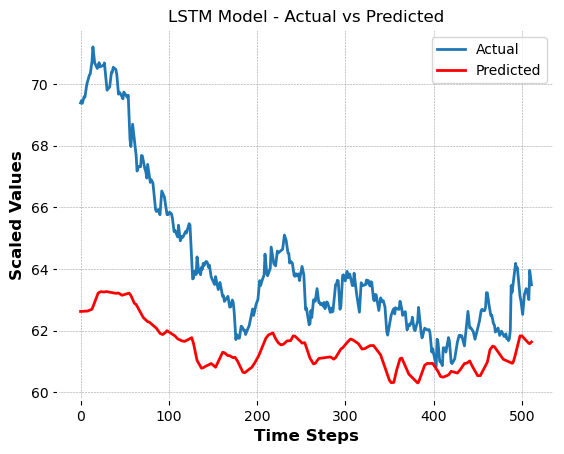

In [129]:
LSTM, prev_sequence, last_sequence, scaler = train_and_test(COCA, lr=0.00001, epochs=30)

###  prophet

In [130]:
def run_prophet(
    data, 
    cross_validate=True, 
    predict=True, 
    periods=50, 
    seasonality_mode='multiplicative', 
    changepoint_prior_scale=0.1, 
    seasonality_prior_scale=5.0, 
    n_changepoints=50, 
    yearly_seasonality=False, 
    weekly_seasonality=True, 
    daily_seasonality=True
):
    """
    Train a Facebook Prophet model on stock market data, perform cross-validation, 
    and make future predictions.

    Parameters:
    - data (pd.DataFrame): DataFrame containing stock market data with 'Datetime', 'Close', 
      'Volume', 'MACD', and 'ATR' columns.
    - cross_validate (bool): Whether to perform cross-validation on the model. Default is True.
    - predict (bool): Whether to make future predictions. Default is True.
    - periods (int): Number of future periods to predict. Default is 50.
    - seasonality_mode (str): Prophet's seasonality mode ('additive' or 'multiplicative'). Default is 'multiplicative'.
    - changepoint_prior_scale (float): Flexibility of the trend change points. Default is 0.1.
    - seasonality_prior_scale (float): Strength of seasonality prior. Default is 5.0.
    - n_changepoints (int): Number of trend changepoints. Default is 50.
    - yearly_seasonality (bool): Enable or disable yearly seasonality. Default is False.
    - weekly_seasonality (bool): Enable or disable weekly seasonality. Default is True.
    - daily_seasonality (bool): Enable or disable daily seasonality. Default is True.

    Returns:
    - prophet (Prophet): Trained Prophet model.
    - transformed_predictions (pd.DataFrame): DataFrame containing log of future predictions.
    - predictions : Actual predictions with logarithm reversed.
    """
    
    # Prepare the dataset
    df = data[['Close', 'Volume', 'MACD', 'ATR']].reset_index()
    df.rename(columns={'Datetime': 'ds', 'Close': 'y'}, inplace=True)
    df['ds'] = df['ds'].dt.tz_localize(None)  # Remove timezone information
    df['y'] = np.log(df['y'])  # Apply log transformation for better trend modeling

    # Create a holiday effect based on US Federal holidays
    calendar = UnitedStates()
    holidays = []
    for year in range(data.index.min().year, data.index.max().year + 2):
        holidays.extend(calendar.holidays(year))
    
    # Convert holiday names to holiday dates
    holiday_dates = [holiday[0] for holiday in holidays]  # Extract dates from holiday objects
    holidays_df = pd.DataFrame({
        'holiday': 'earnings_release',
        'ds': pd.to_datetime(holiday_dates),
        'lower_window': -5,  # Effect starts 5 days before
        'upper_window': 5,   # Effect ends 5 days after
    })
    
    # Initialize Prophet model with provided parameters
    prophet = Prophet(
        seasonality_mode=seasonality_mode, 
        changepoint_prior_scale=changepoint_prior_scale, 
        seasonality_prior_scale=seasonality_prior_scale, 
        holidays=holidays_df,
        n_changepoints=n_changepoints, 
        yearly_seasonality=yearly_seasonality,
        weekly_seasonality=weekly_seasonality,
        daily_seasonality=daily_seasonality
    )
    
    # Add additional regressors
    prophet.add_regressor('Volume')
    prophet.add_regressor('MACD')
    prophet.add_regressor('ATR')
    
    # Train the model
    prophet.fit(df)
    print("Prophet model fitted.\n")
    
    # Perform cross-validation
    if cross_validate:
        print("Starting cross-validation...\n")
        df_cv = cross_validation(prophet, initial='365 days', period='30 days', horizon='90 days')
        df_p = performance_metrics(df_cv)
        print(df_p.head())
        print("Cross-validation finished.\n")
    
    # Prediction phase
    if predict:
        print("Starting prediction...\n")
        
        def predict_regressor(data, regressor, periods):
            """
            Predicts future values of a given regressor using Prophet.

            Parameters:
            - data (pd.DataFrame): Historical dataset containing 'ds' and the specified regressor.
            - regressor (str): Name of the regressor column.
            - periods (int): Number of periods to predict into the future.

            Returns:
            - pd.DataFrame: DataFrame with predicted values for the specified regressor.
            """
            
            model = Prophet(
                seasonality_mode='multiplicative', 
                changepoint_prior_scale=0.1, 
                seasonality_prior_scale=5.0, 
                holidays=holidays_df,
                n_changepoints=50, 
                yearly_seasonality=False, 
                weekly_seasonality=True, 
                daily_seasonality=True
            )
            
            df_reg = data[['ds', regressor]].rename(columns={regressor: 'y'})
            model.fit(df_reg)
            
            future = model.make_future_dataframe(periods=periods)
            future[regressor] = data[regressor]
            
            prediction = model.predict(future)
            return prediction
        
        # Create future dataframe for prediction
        future = prophet.make_future_dataframe(periods=periods)
        
        # Predict each regressor separately
        future['Volume'] = predict_regressor(df, 'Volume', periods)['yhat']
        future['MACD'] = predict_regressor(df, 'MACD', periods)['yhat']
        future['ATR'] = predict_regressor(df, 'ATR', periods)['yhat']
        
        # Generate final predictions
        transformed_predictions = prophet.predict(future)
        predictions = np.exp(transformed_predictions["yhat"])
        print("Finished prediction.")
    
    return prophet, transformed_predictions, predictions


In [131]:
model, preds, actual_predictions = run_prophet(COCA, periods=50)

plot_plotly(model, preds)

22:59:11 - cmdstanpy - INFO - Chain [1] start processing
22:59:24 - cmdstanpy - INFO - Chain [1] done processing


Prophet model fitted.

Starting cross-validation...



  0%|          | 0/10 [00:00<?, ?it/s]22:59:25 - cmdstanpy - INFO - Chain [1] start processing
22:59:34 - cmdstanpy - INFO - Chain [1] done processing
 10%|█         | 1/10 [00:11<01:41, 11.28s/it]22:59:35 - cmdstanpy - INFO - Chain [1] start processing
22:59:46 - cmdstanpy - INFO - Chain [1] done processing
 20%|██        | 2/10 [00:22<01:29, 11.17s/it]22:59:47 - cmdstanpy - INFO - Chain [1] start processing
22:59:58 - cmdstanpy - INFO - Chain [1] done processing
 30%|███       | 3/10 [00:34<01:21, 11.66s/it]22:59:59 - cmdstanpy - INFO - Chain [1] start processing
23:00:07 - cmdstanpy - INFO - Chain [1] done processing
 40%|████      | 4/10 [00:43<01:04, 10.74s/it]23:00:08 - cmdstanpy - INFO - Chain [1] start processing
23:00:16 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 5/10 [00:53<00:50, 10.17s/it]23:00:17 - cmdstanpy - INFO - Chain [1] start processing
23:00:25 - cmdstanpy - INFO - Chain [1] done processing
 60%|██████    | 6/10 [01:01<00:38,  9.66s/it]23:00:27

          horizon       mse      rmse       mae      mape     mdape     smape  \
0 8 days 22:00:00  0.000785  0.028013  0.022849  0.005476  0.004102  0.005467   
1 8 days 23:00:00  0.000795  0.028192  0.023048  0.005524  0.004160  0.005515   
2 9 days 00:00:00  0.000806  0.028382  0.023266  0.005575  0.004230  0.005567   
3 9 days 01:00:00  0.000806  0.028381  0.023272  0.005577  0.004205  0.005568   
4 9 days 18:00:00  0.000813  0.028508  0.023419  0.005612  0.004270  0.005604   

   coverage  
0  0.141395  
1  0.140864  
2  0.139203  
3  0.138206  
4  0.135548  
Cross-validation finished.

Starting prediction...



23:01:07 - cmdstanpy - INFO - Chain [1] start processing
23:01:18 - cmdstanpy - INFO - Chain [1] done processing
23:01:20 - cmdstanpy - INFO - Chain [1] start processing
23:01:38 - cmdstanpy - INFO - Chain [1] done processing
23:01:41 - cmdstanpy - INFO - Chain [1] start processing
23:01:55 - cmdstanpy - INFO - Chain [1] done processing


Finished prediction.


In [132]:
def save_prophet_model(model, model_name):
    """
    Save a trained Prophet model to a specified directory.

    Parameters:
    model (Prophet): The trained Prophet model to be saved.
    model_name (str): The name to be used for the saved model file (without file extension).

    The model will be saved as a .pkl file in the 'models' directory.
    If the 'models' directory doesn't exist, it will be created.

    Example:
    save_prophet_model(model, 'stock_prediction_model')
    """
    # Ensure the models directory exists
    if not os.path.exists('models'):
        os.makedirs('models')
    
    # Define the path to save the model
    model_path = os.path.join('models', f'{model_name}.pkl')
    
    # Save the Prophet model to the specified path
    with open(model_path, 'wb') as f:
        pickle.dump(model, f)
    
    print(f"Model saved as {model_path}")
    
save_prophet_model(model, "test_model")

Model saved as models\test_model.pkl
